In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import numpy as np
from sklearn.preprocessing import OneHotEncoder

## Preprocessing for Cluster Analysis
First, the team created a subset of the necessary data which included sentiment analysis scores and restaurant category. 

In [9]:
sentiment = pd.read_csv('data/sentiments.csv')
clean_sample = pd.read_csv('data/clean-sample.csv')

In [42]:
# Join the sentiment and clean_samlpe datasets on 'Unnamed: 0' column
category_sentiment = pd.merge(clean_sample[['Unnamed: 0', 'general_category']], sentiment[['Unnamed: 0', 'sentiment']], on='Unnamed: 0')

# Drop 'Unamed: 0' column
category_sentiment.drop(columns=['Unnamed: 0'], inplace=True)

Since, general_category is a categorical column, we then one-hot encoded it.

In [30]:
# One-hot encode 'general_category' categorical column while preserving column names
onehot_encoded = OneHotEncoder(sparse=False, categories='auto').fit_transform(category_sentiment[['general_category']])
column_names = [f'{col}_{val}' for val in OneHotEncoder(sparse=False, categories='auto').categories_[0] for col in ['general_category']]    # Sourced: ChatGPT

# Create DataFrame from one-hot encoded columns with original 'general_category' names
category_encoded = pd.DataFrame(onehot_encoded, columns=column_names, index=category_sentiment.index)

# Join the sentiment and clean_samlpe category_encoded
category_sentiment_encoded = pd.concat([category_sentiment.drop(columns=['general_category']), category_encoded], axis=1)

c:\Users\sofia\OneDrive\Documents\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Then, we performed an Elbow plot to understand how many clusters would be optimal when running the K-means analysis.

  0%|          | 0/9 [00:00<?, ?it/s]c:\Users\sofia\OneDrive\Documents\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 11%|█         | 1/9 [00:00<00:06,  1.24it/s]c:\Users\sofia\OneDrive\Documents\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 22%|██▏       | 2/9 [00:01<00:06,  1.13it/s]c:\Users\sofia\OneDrive\Documents\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_ini

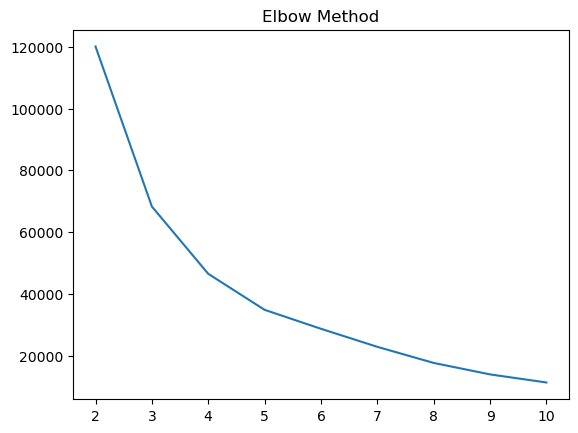

In [38]:
# Elbow plot

inertias = []
ks = range(2, 11)

for k_ in tqdm(ks):
  kmeans_result = (KMeans(n_clusters=k_, random_state = 88).fit(category_sentiment_encoded))
  inertias.append(kmeans_result.inertia_)

plt.plot(ks, inertias, label = 'inertia')
plt.xticks(ks)
plt.title('Elbow Method')
plt.show()

When looking at the chart, it was evident that 4 clusters would be best. Therefore, the team proceeded to standardize the data.

In [35]:
# Standardize data
sc = StandardScaler()
scaled_category_sentiment = pd.DataFrame(sc.fit_transform(category_sentiment_encoded), columns=category_sentiment_encoded.columns)

## Clustering Steps
We then proceeded to perform the K-means cluster analysis and assigned each point to its cluster by creating a 'cluster_labels' column.

In [37]:
# K Means Clustering
num_cluster = 4
kmeans_result = KMeans(num_cluster, init='random').fit(scaled_category_sentiment)

# Assign each point to its cluster
scaled_category_sentiment['cluster_labels'] = kmeans_result.labels_

# View how many data points are in each label
print(scaled_category_sentiment['cluster_labels'].value_counts())

c:\Users\sofia\OneDrive\Documents\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


1    135541
2     92258
3     52104
0     30190
Name: cluster_labels, dtype: int64


Next, we explored the average metrics accross cluster to understand them better.

In [40]:
# Group data by 'cluster_labels'
cluster_groups = scaled_category_sentiment.groupby('cluster_labels')

# Calculate the average metrics within each cluster
avg_cluster_metrics = cluster_groups.mean()

# Print average metrics across clusters
print(avg_cluster_metrics)

                sentiment  general_category_Auto  general_category_Bars  \
cluster_labels                                                            
0                0.003619              -0.141608               3.044894   
1                0.000940              -0.141608              -0.328419   
2               -0.002035              -0.141608              -0.328419   
3               -0.000939               0.701161              -0.328419   

                general_category_Beauty  general_category_Coffee_Tea  \
cluster_labels                                                         
0                             -0.220558                    -0.041572   
1                             -0.220558                    -0.041572   
2                             -0.220558                    -0.041572   
3                              1.092078                     0.205843   

                general_category_Education  general_category_Entertainment  \
cluster_labels                        

# Don't forget Analysis !!!!!!
